In [1]:
import numpy as np
import sys
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
sys.path.append('../') # Add parent directory to the system path

In [2]:
from direct_decomposition import direct_decomposition
import interferometer as itf

In [5]:
# Unitaries for the R = 1/2, R = 1/3 and the flipped R = 1/3 beamsplitters
U_onehalf = 1/np.sqrt(2) * np.matrix([[1,1],[1,-1]])

a = np.sqrt(1/3) # a and b are placeholders
b = np.sqrt(2/3)
U_onethird = np.matrix([[a,b],[b,-a]])
U_flipped_onethird = np.matrix([[-a,b],[b,a]])

In [16]:
# Get theta and phi values for beamsplitters according to itf decomposition
BS_onehalf = itf.square_decomposition(U_onehalf)
BS_onethird = itf.square_decomposition(U_onethird)
BS_flipped_onethird = itf.square_decomposition(U_flipped_onethird)

print(BS_onehalf.BS_list)
print(BS_onethird.BS_list)
print(BS_flipped_onethird.BS_list)

print(BS_onethird.BS_list[0].theta)

[
 Beam splitter between modes 1 and 2: 
 Theta angle: 0.79 
 Phase: 3.14]
[
 Beam splitter between modes 1 and 2: 
 Theta angle: 0.96 
 Phase: 3.14]
[
 Beam splitter between modes 1 and 2: 
 Theta angle: 0.96 
 Phase: 0.00]
0.9553166181245093


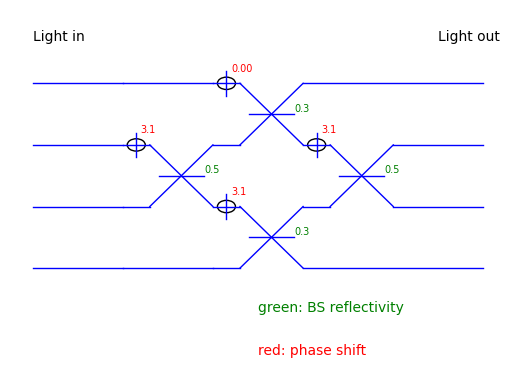

In [18]:
# Make interferometer
# Usage: Beamsplitter(mode1, mode2, theta, phi)
theta3 = 0.9553166181245093
bs1 = itf.Beamsplitter(2, 3, np.pi/4, np.pi)
bs2 = itf.Beamsplitter(1, 2, theta3, 0)
bs3 = itf.Beamsplitter(3, 4, theta3, np.pi)
bs4 = itf.Beamsplitter(2, 3, np.pi/4, np.pi)

I = itf.Interferometer()
for bs in [bs1, bs2, bs3, bs4]:
    I.add_BS(bs)

I.draw()


In [21]:
# U = I.calculate_transformation()
# test = itf.square_decomposition(U)
# test.draw()
# There are some slight variations... It should be fine?

In [23]:
U = I.calculate_transformation()
CNOT_circuit = direct_decomposition(U, 2)
print(CNOT_circuit.num_qubits)
print(CNOT_circuit.depth())

8
580


In [24]:
# Initial states for CNOT simulation
c1_t0 = QuantumCircuit(CNOT_circuit.num_qubits) # One photon in mode c1, one photon in mode t0
c1_t0.x(0)
c1_t0.x(2)

c1_t1 = QuantumCircuit(CNOT_circuit.num_qubits) # One photon in mode c1, one photon in mode t1
c1_t1.x(0)
c1_t1.x(4)

In [38]:
circ = c1_t0.compose(CNOT_circuit, qubits=list(range(c1_t0.num_qubits)), inplace=False)
circ.measure_all()

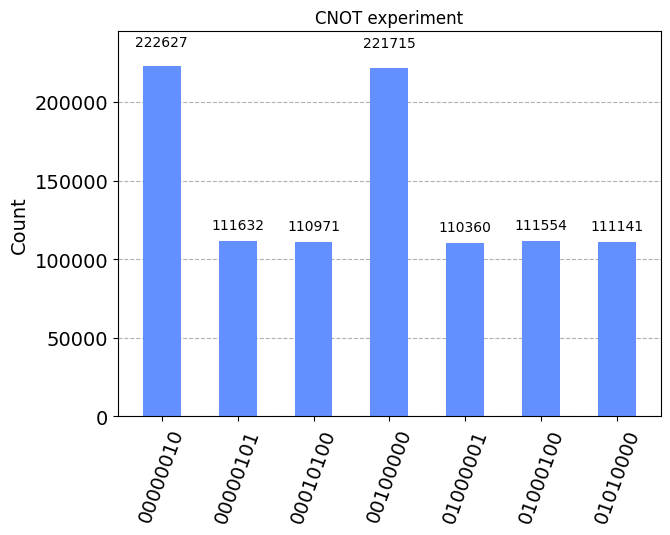

In [39]:
num_shots = 1e6
simulator = AerSimulator()
circ = transpile(circ, simulator)
result = simulator.run(circ, shots=num_shots).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='CNOT experiment')